# Compiled Implementation of Shor's Algorithm Using IBM's Q Experience

### General Outline of Shor's Algorithm
1. Choose a random integer m such that m < N and they are coprime
2. Find the period P of the function: f(x) = mx mod N
3. If P is odd, try step 2 with another integer m, if P is even, go to step 4
4. (mP/2 + 1)(mP/2 - 1) = mP - 1 = 0 mod N
    If mP/2 + 1 = 0 mod N, go back to step 1
    If mP/2 + 1 ≠ 0 mod N, go to step 5
5. Compute gcd(mP/2 ± 1, N) which are the non-trivial factors of N

This Code is an expansion on step 2, which is the only element of Shor's Algorithm that requires a Quantum Computer

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit.compiler import transpile, assemble
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [1]:
import numpy as np
import math
import qiskit as q
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_hinton

### Period Finding Algorithm (N=15, m = 11)
Traditionally Shor's Algorithm takes 2n + 3 qubits, however as shown in Michael R. Geller's & Zhongyuan Zhou's paper: https://www.nature.com/articles/srep03023, when the integer is a product of two Fermat primes, it can be solved in much less. Often when you see examples of Shor's Algorithm being implemented in academic papers, they will use these numbers and this is the reason why. Because you need to know the period to implement the compiled version of modular exponentiation this is more of a toy example and should'nt be taken as a general implementation.

The goal of the period finding algorithm is to find the period of the function m^x mod N. To show how this function is indeed periodic I've included an example below. As you can see with N = 15 and m = 11, the period is 2.

In [2]:
N = 15
m = 11
for i in range(10):
    mod = (m**i) % N
    print(mod)

1
11
1
11
1
11
1
11
1
11


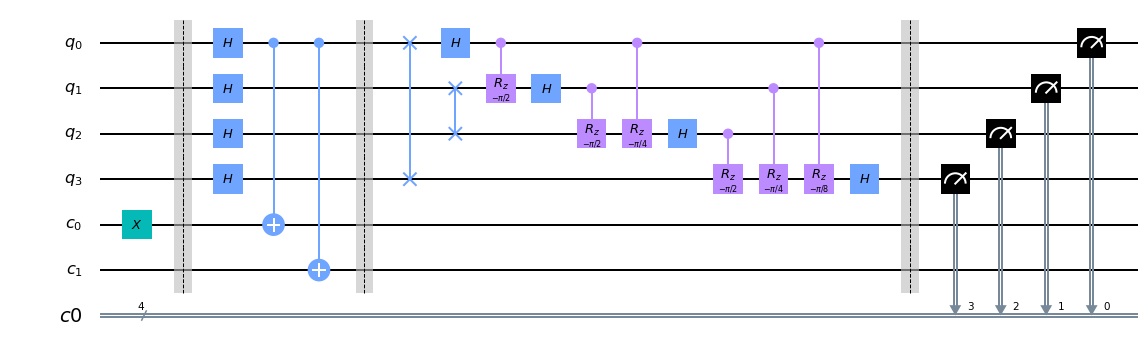

In [3]:
pi = np.pi

qc_q = QuantumRegister(4, 'q') #Initialize the Working Register
qc_c = QuantumRegister(2, 'c') #Initialize the Control Register
c = ClassicalRegister(4) #Register which will eventually hold measurements
Shor = QuantumCircuit(qc_q, qc_c,c)

Shor.x(4) # It is common convention to add a not gate before Modular Exponentiation
Shor.barrier()

Shor.h(qc_q[0:4]) #Initialize 4 Hadamard Gates to allow for all possibilities

#This is a compiled version of modular exponentiation that will not generalize outside of fermat primes.
Shor.cx(qc_q[0],qc_c[0]) 
Shor.cx(qc_q[0],qc_c[1])
Shor.barrier()

#This can be ommited by classically swapping the order of measurments if noise is an issue.
Shor.swap(qc_q[0],qc_q[3])
Shor.swap(qc_q[1],qc_q[2])

#The Inverse Quantum Fourier Transform
Shor.h(0)
Shor.crz(-pi/2,qc_q[0],qc_q[1])
Shor.h(1)

Shor.crz(-pi/2,qc_q[1],qc_q[2])
Shor.crz(-pi/4,qc_q[0],qc_q[2])
Shor.h(2)

Shor.crz(-pi/2,qc_q[2],qc_q[3])
Shor.crz(-pi/4,qc_q[1],qc_q[3])
Shor.crz(-pi/8,qc_q[0],qc_q[3])
Shor.h(3)

Shor.barrier()

#Measure Working Register
Shor.measure(qc_q[3],3)
Shor.measure(qc_q[2],2)
Shor.measure(qc_q[1],1)
Shor.measure(qc_q[0],0)

Shor.draw(output='mpl')

In [6]:
simulator = Aer.get_backend('qasm_simulator')
backend = provider.get_backend("ibmq_16_melbourne")

# Replace simulator in execute function with 'backend' to run on a quantum computer
job = execute(Shor, simulator, shots=5000)
result = job.result()
counts = result.get_counts(Shor)

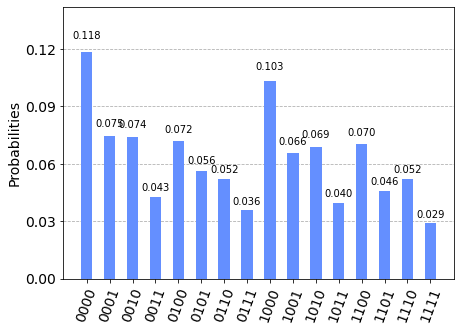

In [7]:
plot_histogram(counts)

# How to Interpret the results
The correct answer should be a multiple of 2^n/r where r is the period and n is the number of qubits in the working register. So the correct measurement should be a multiple of 8. Our two peaks occur at 0 and 8, so we know it is correct. Although this is a little backwards, it's assumed a classical computer can take the measurements and return the period in polynomial time.